# Evaluation wrt GT

In [1]:
import numpy as np
import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics

import matplotlib.pyplot as plt
from pose_trajectory_evaluation import PoseTrajectoryEvaluation

%matplotlib inline
# %matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
export_path = '/mnt/data/logs/maplab_profiles/'
n = 3

est_trajectories = []
gt_trajectories = []
config_files = []

for i in range(1, n+1):
    config_filename = export_path + 'config-top-' + str(i) + '.txt'
    est_traj_filename = export_path + 'est-traj-top-' + str(i) + '.npy'
    gt_traj_filename = export_path + 'gt-traj-top-' + str(i) + '.npy'

    config_files.append(config_filename)
    est_trajectories.append(np.load(est_traj_filename))
    gt_trajectories.append(np.load(gt_traj_filename))
assert len(config_files) == len(est_trajectories)
assert len(config_files) == len(gt_trajectories)


In [3]:
def convert_to_traj(trajectory):
    ts = trajectory[:,0]
    xyz = trajectory[:,1:4]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

idx = 0

est_traj = convert_to_traj(est_trajectories[idx])
gt_traj = convert_to_traj(gt_trajectories[idx])

In [4]:
delta = 5
delta_unit = metrics.Unit.frames
all_pairs = False
data = (gt_traj, est_traj)

print('--- Translational Part -----------------------------')
pose_relation = metrics.PoseRelation.translation_part
print('APE:')
ape_metric_trans = metrics.APE(pose_relation)
ape_metric_trans.process_data(data)
ape_stat_trans = ape_metric_trans.get_statistic(metrics.StatisticsType.rmse)
ape_stats_trans = ape_metric_trans.get_all_statistics()
pprint.pprint(ape_stats_trans)

print('RPE:')
rpe_metric_trans = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric_trans.process_data(data)
rpe_stat_trans = rpe_metric_trans.get_statistic(metrics.StatisticsType.rmse)
rpe_stats_trans = rpe_metric_trans.get_all_statistics()
pprint.pprint(rpe_stats_trans)
print('\n\n')

print('--- Rotational Part -----------------------------')
pose_relation = metrics.PoseRelation.rotation_angle_deg
print('APE:')
ape_metric_rot = metrics.APE(pose_relation)
ape_metric_rot.process_data(data)
ape_stat_rot = ape_metric_rot.get_statistic(metrics.StatisticsType.rmse)
ape_stats_rot = ape_metric_rot.get_all_statistics()
pprint.pprint(ape_stats_rot)

print('RPE:')
rpe_metric_rot = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric_rot.process_data(data)
rpe_stat_rot = rpe_metric_rot.get_statistic(metrics.StatisticsType.rmse)
rpe_stats_rot = rpe_metric_rot.get_all_statistics()
pprint.pprint(rpe_stats_rot)

--- Translational Part -----------------------------
APE:
{'max': 0.7646661178128733,
 'mean': 0.2284515359645761,
 'median': 0.06295272547784657,
 'min': 0.01839953433193624,
 'rmse': 0.36432208697668567,
 'sse': 20.971432123329535,
 'std': 0.28379654468381693}
RPE:
{'max': 0.15530733579900344,
 'mean': 0.007820253005048853,
 'median': 0.002061651491720943,
 'min': 0.00014763952588290745,
 'rmse': 0.019856461112304557,
 'sse': 0.0619018105210007,
 'std': 0.01825164898965262}



--- Rotational Part -----------------------------
APE:
{'max': 3.948045924861502,
 'mean': 1.536273747366521,
 'median': 0.52631320795261,
 'min': 0.3846021262778006,
 'rmse': 2.034058274431145,
 'sse': 653.7081040775255,
 'std': 1.3331376661598886}
RPE:
{'max': 0.4211312795616365,
 'mean': 0.06485693768573368,
 'median': 0.04067378396711178,
 'min': 0.004676820341532323,
 'rmse': 0.09571365900402533,
 'sse': 1.4382934096303979,
 'std': 0.07038950315187412}


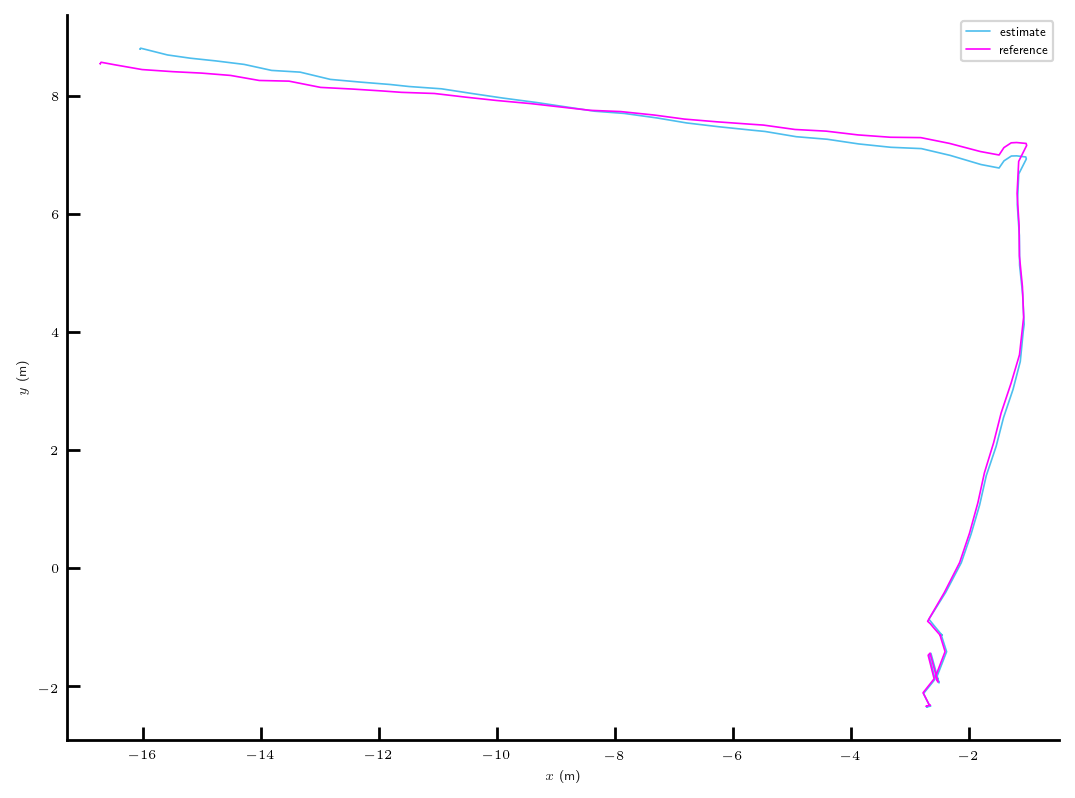

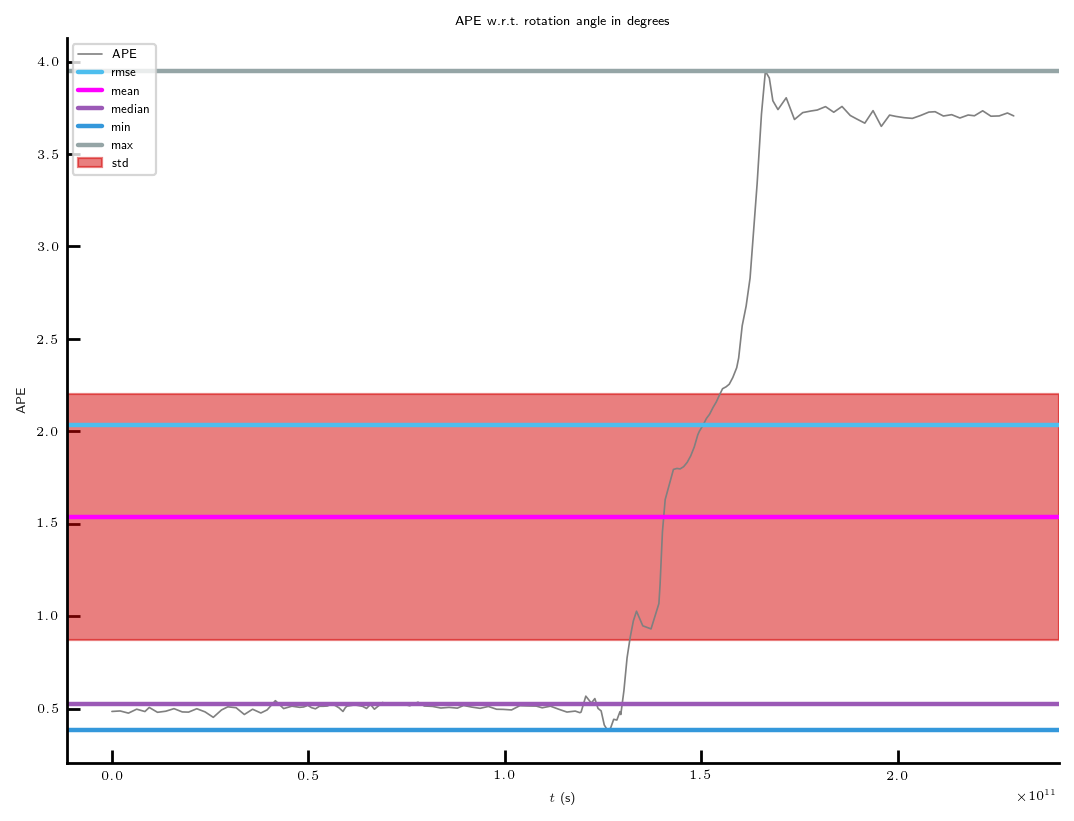

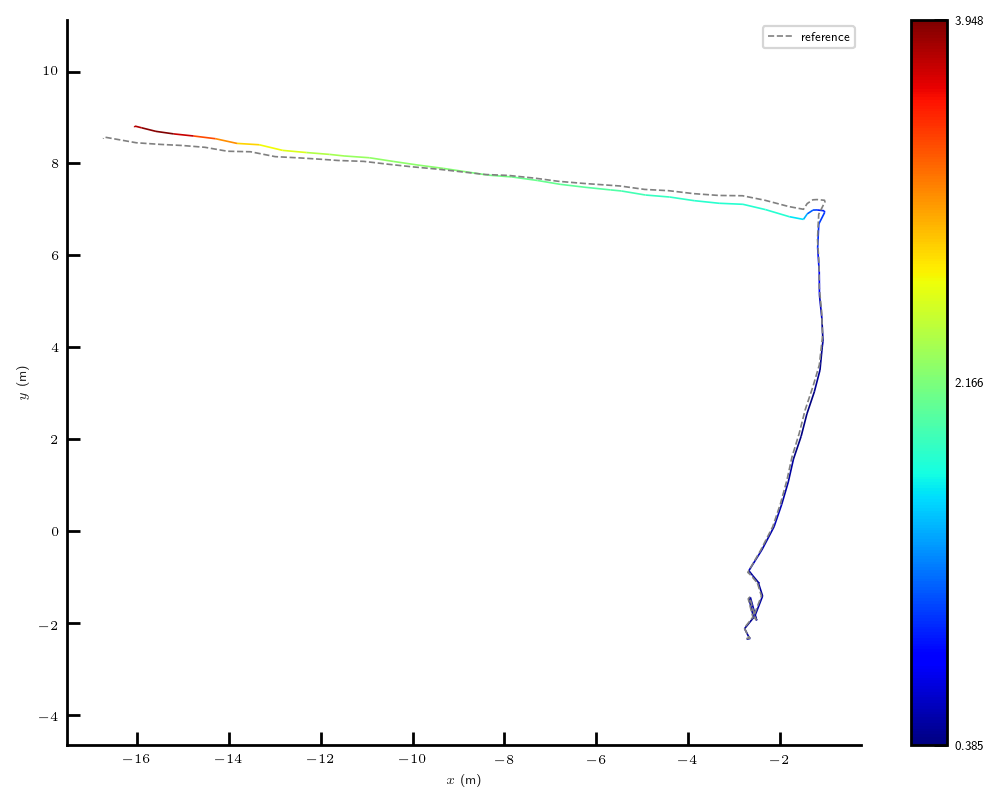

In [10]:
# Trajectory plot
fig = plt.figure(figsize=(8, 6), dpi=160)
traj_by_label = {
    "estimate": est_traj,
    "reference": gt_traj
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()

# Trajectory plot
seconds_from_start = [t - est_traj.timestamps[0] for t in est_traj.timestamps]
fig = plt.figure(figsize=(8, 6), dpi=160)
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
plot.traj_colormap(ax, est_traj, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()